In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import geopandas as gpd
import osmium
from shapely.geometry import Polygon
import json
import fiona
import os
from shapely.geometry import shape 
import contextily as ctx
from sklearn.preprocessing import OneHotEncoder
from shapely.geometry import Point, Polygon
import folium
from zipfile import ZipFile
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
import seaborn as sns
from shapely.geometry import Point, LineString, MultiPoint
import requests
from io import BytesIO, StringIO
import contextily as ctx
from IPython.display import HTML, display, IFrame
import osmnx as ox
import osmium
from osm_runner import Runner
import regex as re
import unicodedata
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import osmnx as ox
import osmium




for module in [pd, gpd]:
    print(module.__name__, module.__version__)

pandas 1.2.4
geopandas 0.9.0


In [2]:
pd.set_option('display.max_columns', None)

# Loading Data 

## Challenge Data

In [116]:
green_areas = pd.read_csv('https://raw.githubusercontent.com/SowmyaMadala/WDL-Stage4/main/Data/Attracting%20Population/WDL_Green_Areas_Dataset_V1.txt', 
                          sep ="|", 
                          encoding ="latin-1").rename(columns = {'Number of Museums in influence area' : 'no_of_museums',
                                                                 'Number of parking lots in influence area' : 'no_of_parking_lots',
                                                                'Number of tourist attractions in influence area': 'no_of_tourist_attractions', 
                                                                'Green Zones Daily Average Demand':'gz_daily_avg_demand',
                                                                'Daily average of people in influence area': 'daily_avg_people',
                                                                'Number of buildings in influence area' : 'no_of_buildings',
                                                                'Number of families in influence area': 'no_of_families',
                                                                'Number of people resident in influence area' : 'no_of_people_resident'
                                                                })

green_areas.shape, green_areas.dtypes


((128, 14),
 Green_Zone_name               object
 no_of_museums                  int64
 no_of_parking_lots             int64
 no_of_tourist_attractions      int64
 gz_daily_avg_demand          float64
 Resident                       int64
 daily_avg_people             float64
 no_of_buildings                int64
 no_of_families                 int64
 no_of_people_resident          int64
 perc_senior_pop              float64
 perc_pop_until_19_yo         float64
 POINT_X                      float64
 POINT_Y                      float64
 dtype: object)

In [117]:
# turn green areas into geo df
res_green_areas = green_areas[green_areas.Resident == 1] # only residential data
res_green_areas['latlng'] = res_green_areas.apply(lambda x: (x.POINT_Y, x.POINT_X), axis=1)
res_green_areas['geometry'] = res_green_areas.apply(lambda x: Point(x.POINT_X, x.POINT_Y), axis=1)
geo_green_areas = gpd.GeoDataFrame(res_green_areas.drop(columns=['POINT_X', 'POINT_Y'])).reset_index()
# set crs EPSG=4326 (WGS84 latitude-longitude projection)
geo_green_areas = geo_green_areas.set_crs("EPSG:4326")

<ipython-input-117-01c984405eca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_green_areas['latlng'] = res_green_areas.apply(lambda x: (x.POINT_Y, x.POINT_X), axis=1)
<ipython-input-117-01c984405eca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_green_areas['geometry'] = res_green_areas.apply(lambda x: Point(x.POINT_X, x.POINT_Y), axis=1)


## Parish data

In [118]:
# get parish code poly
# url = 'http://mapas.dgterritorio.pt/ATOM-download/CAOP-Cont/Cont_AAD_CAOP2020.zip'
path = 'map_data/Cont_AAD_CAOP2020'
parishes = gpd.read_file(path)
parishes.shape

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3223, 9)

In [119]:
# transform the parishes to the same projection
parishes_proj = parishes.copy()[['Dicofre', 'geometry']]
parishes_proj = parishes_proj.to_crs("EPSG:4326")

# perform the join
green_areas_dic = gpd.sjoin(geo_green_areas, 
                  parishes_proj, 
                  how='left', 
                  op='within',
                 ).drop(columns=['index_right'])

In [120]:
# green_areas_dic

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Distribution of Dicofres in the set')

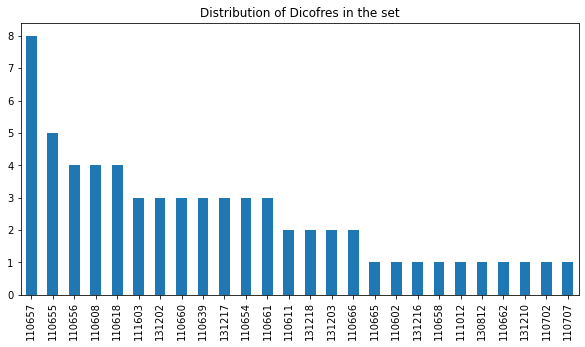

In [121]:
green_areas_dic.Dicofre.value_counts().plot(kind='bar',
                                           figsize=(10,5))
plt.title('Distribution of Dicofres in the set')

# Get OSM green spaces shapes

In [122]:
def get_amenities(df,
                  tags = {'amenity': False,
                            'leisure': True,
                            'tourism': False,
                            'natural': False,
                            'shop': False
                           }, 
                  shapes=False):
    """
    1. returns shapes of parks as Polygons
    2. returns all queried amenities inside a shape (Polygon) from OSM
    """
    # create empty list
    ins = []
    
    # iterate through df

        
    if shapes:
        for c, row in df.iterrows(): # first .head(), later all
            # check for inside of park amenities
            geom = row.geometry
            print(row.Green_Zone_name)
            # check for inside padded park amenities
            insides = ox.geometries.geometries_from_polygon(row.geometry,
                                                               tags=tags)
            insides['match'] = row['index']

            ins.append(insides)
    else:
        for c, row in df.iterrows(): # first .head(), later all
            # check for inside of park amenities
            print(row.Green_Zone_name)
        
            # https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.geometries.geometries_from_place
            parks = ox.geometries.geometries_from_point(center_point=row.latlng, 
                                                           tags=tags, 
                                                           dist=100)

            parks['match'] = row['index']
            ins.append(parks)

    
    
    must = ['geometry',
            'name', 
            'match']
    
    opt = [k for k,v in tags.items() if v]
    
    columns = must + opt
    concat = pd.concat(ins)[columns]
    
    return concat

In [10]:
parks = get_amenities(green_areas_dic, tags = {'leisure': True})

ESPAÇO JOGO E RECREIO HOMEM DO LEME
JARDIM AFONSO DE ALBUQUERQUE
JARDIM ALAMEDA CIDADE UNIVERSITÁRIA
JARDIM ALAMEDA DOM AFONSO HENRIQUES
JARDIM AMÁLIA RODRIGUES
JARDIM AMÉLIA CARVALHEIRA
JARDIM ANTÓNIO NOBRE
JARDIM AVELAR BROTERO
JARDIM BASÍLIO TELES
JARDIM BENTO MARTINS
JARDIM BOTÂNICO LISBOA
JARDIM BOTÂNICO PORTO
JARDIM BRAAMCAMP FREIRE
JARDIM CONSTANTINO
JARDIM DA BOAVISTA
JARDIM DA CORUJEIRA
JARDIM DA LUZ
JARDIM DA RIBEIRA DAS NAUS
JARDIM DAS AMOREIRAS
JARDIM DE BUCELAS
JARDIM DE LOPES DE MENDONÇA
JARDIM DE SANTOS
JARDIM DE TEÓFILO BRAGA
JARDIM DO ARCO DO CEGO
JARDIM DO CAMPO GRANDE
JARDIM DO CAMPO PEQUENO
JARDIM DO PALÁCIO DA BOLSA
JARDIM DO PALÁCIO DE BEAU-SÉJOUR
JARDIM DO PALÁCIO DE CRISTAL
JARDIM DO PRÍNCIPE REAL
JARDIM DOM LUÍS I
JARDIM FERNANDO PESSA
JARDIM FRANCISCO CALDEIRA CABRAL
JARDIM FRANCISCO SÁ CARNEIRO
JARDIM FUNDAÇÃO CALOUSTE GULBENKIAN
JARDIM GARCIA DORTA
JARDIM IRMÃ LÚCIA
JARDIM JOÃO FREDERICO LUDOVICE
JARDIM LISBOA ANTIGA
JARDIM NOVE DE ABRIL
JARDIM PAULO VALLADA

In [123]:
parks.match.value_counts()

57     23
23     11
125     8
81      8
75      8
       ..
31      1
29      1
13      1
5       1
109     1
Name: match, Length: 61, dtype: int64

In [124]:
# group the findings by the first finding
by_match = parks.groupby('match').first() # the first one seems to be the park
# Moving the old Points to another column
green_areas_dic['Points'] = green_areas_dic.geometry
green_areas_dic = green_areas_dic.drop(columns=['geometry'])
# merge the df with the matched 'parks' from the OSM request
green_areas_shape = green_areas_dic.copy().merge(by_match['geometry'], 
                                        how='left', 
                                        left_on='index', # the indexes were still the same
                                        right_index=True).sort_index()

In [125]:
green_areas_shape.head(3)

,index,Green_Zone_name,no_of_museums,no_of_parking_lots,no_of_tourist_attractions,gz_daily_avg_demand,Resident,daily_avg_people,no_of_buildings,no_of_families,no_of_people_resident,perc_senior_pop,perc_pop_until_19_yo,latlng,Dicofre,Points,geometry
0,0,ESPAÇO JOGO E RECREIO HOMEM DO LEME,5,28,30,3.728677,1,17780.803014,4783,15352,38012,0.195123,0.196017,"(41.16001, -8.68415)",131216,POINT (-8.68415 41.16001),"POLYGON ((-8.68544 41.16198, -8.68570 41.16189..."
1,3,JARDIM AFONSO DE ALBUQUERQUE,93,129,78,10.259113,1,17497.825376,1775,17185,41163,0.161747,0.204917,"(38.69674, -9.19949)",110658,POINT (-9.19949 38.69674),"POLYGON ((-9.20107 38.69706, -9.19972 38.69729..."
2,5,JARDIM ALAMEDA CIDADE UNIVERSITÁRIA,8,23,4,47.347816,1,17497.825376,1775,17185,41163,0.161747,0.204917,"(38.75294, -9.15757)",110654,POINT (-9.15757 38.75294),"MULTIPOLYGON (((-9.15553 38.75406, -9.15551 38..."


In [126]:
# check if some shapes are still missing
idxs = green_areas_shape.geometry.isna()
idxs.sum()
print(green_areas_shape.loc[idxs[idxs].keys()].Green_Zone_name)
# 3 shapes are missing

49                PARQUE INFANTIL DO IPO
52    PARQUE RECREATIVO ALTO DA SERAFINA
56              PARQUE URBANO DO SILVADO
Name: Green_Zone_name, dtype: object


/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
# fix the missing park shapes, do buffered points
green_areas_shape['geometry'] = green_areas_shape.apply(lambda x: x.geometry if x.geometry else x.Points.buffer(.003), axis=1)
(green_areas_shape.geometry == None).sum()

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0

# Get OSM amenities

In [128]:
# buffer green areas to get their sorrounding
green_areas_buff = green_areas_shape.copy().set_crs(epsg=4326)
green_areas_buff['geometry'] = green_areas_buff.geometry.to_crs(epsg=4326).buffer(.001)

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-128-fdc4967997c6>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  green_areas_buff['geometry'] = green_areas_buff.geometry.to_crs(epsg=4326).buffer(.001)


In [17]:
# fetch amenities
all_amenities = get_amenities(green_areas_buff,
                             tags = {'amenity': True,
                                    'leisure': True,
                                    'tourism': True,
                                    'natural': True,
                                    'shop': True
                                   }, 
                                   shapes=True)

ESPAÇO JOGO E RECREIO HOMEM DO LEME
JARDIM AFONSO DE ALBUQUERQUE
JARDIM ALAMEDA CIDADE UNIVERSITÁRIA
JARDIM ALAMEDA DOM AFONSO HENRIQUES
JARDIM AMÁLIA RODRIGUES
JARDIM AMÉLIA CARVALHEIRA
JARDIM ANTÓNIO NOBRE
JARDIM AVELAR BROTERO
JARDIM BASÍLIO TELES
JARDIM BENTO MARTINS
JARDIM BOTÂNICO LISBOA
JARDIM BOTÂNICO PORTO
JARDIM BRAAMCAMP FREIRE
JARDIM CONSTANTINO
JARDIM DA BOAVISTA
JARDIM DA CORUJEIRA
JARDIM DA LUZ
JARDIM DA RIBEIRA DAS NAUS
JARDIM DAS AMOREIRAS
JARDIM DE BUCELAS
JARDIM DE LOPES DE MENDONÇA
JARDIM DE SANTOS
JARDIM DE TEÓFILO BRAGA
JARDIM DO ARCO DO CEGO
JARDIM DO CAMPO GRANDE
JARDIM DO CAMPO PEQUENO
JARDIM DO PALÁCIO DA BOLSA
JARDIM DO PALÁCIO DE BEAU-SÉJOUR
JARDIM DO PALÁCIO DE CRISTAL
JARDIM DO PRÍNCIPE REAL
JARDIM DOM LUÍS I
JARDIM FERNANDO PESSA
JARDIM FRANCISCO CALDEIRA CABRAL
JARDIM FRANCISCO SÁ CARNEIRO
JARDIM FUNDAÇÃO CALOUSTE GULBENKIAN
JARDIM GARCIA DORTA
JARDIM IRMÃ LÚCIA
JARDIM JOÃO FREDERICO LUDOVICE
JARDIM LISBOA ANTIGA
JARDIM NOVE DE ABRIL
JARDIM PAULO VALLADA

In [18]:
# all_amenities

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [129]:
all_amenities.match.value_counts()

9      137
57     136
49      74
44      58
99      57
      ... 
109      2
87       1
19       1
15       1
64       1
Name: match, Length: 64, dtype: int64

In [130]:
# the polygons of the actual green spaces are also in the data set
prks = all_amenities[(all_amenities['leisure'] == 'park') | (all_amenities['leisure'] == 'garden')]
all_amenities = all_amenities.drop(prks.index) # remove the used shapes for the parks

# Transforming OSM features

In [131]:
# reducing geo_df columns, only leavin one valid column
def new_desc(geo):
    geo['desc'] = None
    lst_cols = ['amenity',
                'leisure',
                'tourism',
                'natural',
                'shop',
                'geometry',
                'name', 
                'match']
    for c, row in geo.iterrows():
        # listing all appearing POIs in one cell with a concat name
        trues = [f'{i}_{row[i]}' for i in lst_cols if row[i] == row[i]]
        if len(trues) > 0:
            geo.at[c, 'desc'] = trues[0]
        else: 
            geo.at[c, 'desc'] = None
        print(f'done: {c}')
        
    
    geo = geo[['geometry', 'desc', 'match']]
    geo = geo.dropna(subset=['desc'])
    geo= geo.reset_index(drop=True)
    
    return geo

desc_geo = new_desc(all_amenities.copy())

done: 0
done: 9
done: 10
done: 12
done: 0
done: 9
done: 10
done: 12
done: 0
done: 9
done: 10
done: 12
done: 0
done: 9
done: 10
done: 12
done: 60
done: 62
done: 63
done: 64
done: 65
done: 66
done: 67
done: 68
done: 71
done: 73
done: 74
done: 79
done: 81
done: 82
done: 0
done: 9
done: 10
done: 12
done: 60
done: 62
done: 63
done: 64
done: 65
done: 66
done: 67
done: 68
done: 71
done: 73
done: 74
done: 79
done: 81
done: 82
done: 83
done: 84
done: 85
done: 86
done: 87
done: 88
done: 89
done: 90
done: 91
done: 92
done: 93
done: 95
done: 96
done: 98
done: 101
done: 102
done: 106
done: 107
done: 108
done: 109
done: 110
done: 112
done: 113
done: 114
done: 116
done: 117
done: 121
done: 122
done: 123
done: 124
done: 125
done: 126
done: 130
done: 131
done: 133
done: 134
done: 136
done: 137
done: 138
done: 140
done: 141
done: 142
done: 143
done: 144
done: 145
done: 146
done: 148
done: 149
done: 150
done: 151
done: 152
done: 153
done: 154
done: 155
done: 156
done: 157
done: 159
done: 160
done: 161
do

In [132]:
desc_geo.sample(5)
# sowing all POIs in one column with a defined name

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,geometry,desc,match
369,POINT (-8.61226 41.15556),amenity_parking,44
654,POINT (-9.15660 38.73639),natural_tree,69
252,POINT (-8.64208 41.15406),amenity_fast_food,23
823,"POLYGON ((-9.17450 38.79907, -9.17478 38.79917...",amenity_fast_food,109
53,POINT (-9.15380 38.73038),amenity_charging_station,9


In [133]:
desc_geo.desc.value_counts()

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


natural_tree                466
amenity_fast_food           119
amenity_restaurant           66
amenity_parking              57
amenity_charging_station     18
leisure_outdoor_seating      16
tourism_hotel                14
leisure_pitch                14
leisure_swimming_pool        13
natural_water                12
amenity_school               11
amenity_fountain             11
amenity_place_of_worship      9
amenity_hospital              7
amenity_theatre               7
amenity_post_office           6
amenity_bench                 4
shop_coffee                   2
tourism_information           2
amenity_post_box              2
leisure_stadium               2
amenity_toilets               2
tourism_attraction            1
Name: desc, dtype: int64

In [134]:
# encoding all unique values
encoder = OneHotEncoder()
enc_df = encoder.fit_transform(desc_geo[['desc']])
enc_gdf_points = gpd.GeoDataFrame(enc_df.toarray(), columns=encoder.categories_)
enc_gdf_points = enc_gdf_points.join(desc_geo[['geometry', 'match']])
columns = enc_gdf_points.columns

In [135]:
rename = {i:f'feat_{i[0]}' for i in columns if type(i)==tuple}
enc_gdf_points = enc_gdf_points.rename(columns=rename)
# enc_gdf_points = enc_gdf_points.set_crs(epsg=4326)
enc_gdf_points = enc_gdf_points.rename(columns={'geometry':'points_feats'})
enc_gdf_points.shape # 25 columns

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(861, 25)

In [136]:
enc_gdf_points.points_feats.type.unique()

array(['Point', 'Polygon', 'LineString'], dtype=object)

In [139]:
len(enc_gdf_points.match.value_counts())

64

# Join OSM and green zones

In [138]:
enc_gdf_points = enc_gdf_points.merge(green_areas_buff, left_on='match', right_on='index')

In [140]:
# prepare aggregation dict
columns_points = enc_gdf_points.columns
green_cols = green_areas_buff.columns

agg_feat = {i:'sum' for i in columns_points if 'feat_' in i} # summing equal features
agg_green = {i:'first' for i in green_cols if i != 'match'} # index to be grouped by
agg = dict(agg_feat)
agg.update(agg_green)
agg['points_feats'] = lambda x: list(x) # listing their relative geometries

In [141]:
# regrouping by green_areas index => caught all the points
grouped_gpd = enc_gdf_points.groupby('match').agg(agg)

grouped_gpd.shape, grouped_gpd.columns[-30:]

((64, 41),
 Index(['feat_amenity_theatre', 'feat_amenity_toilets',
        'feat_leisure_outdoor_seating', 'feat_leisure_pitch',
        'feat_leisure_stadium', 'feat_leisure_swimming_pool',
        'feat_natural_tree', 'feat_natural_water', 'feat_shop_coffee',
        'feat_tourism_attraction', 'feat_tourism_hotel',
        'feat_tourism_information', 'index', 'Green_Zone_name', 'no_of_museums',
        'no_of_parking_lots', 'no_of_tourist_attractions',
        'gz_daily_avg_demand', 'Resident', 'daily_avg_people',
        'no_of_buildings', 'no_of_families', 'no_of_people_resident',
        'perc_senior_pop', 'perc_pop_until_19_yo', 'latlng', 'Dicofre',
        'Points', 'geometry', 'points_feats'],
       dtype='object'))

In [142]:
geo_grouped_gpd = gpd.GeoDataFrame(grouped_gpd)
geo_grouped_gpd.crs

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [143]:
geo_grouped_gpd.shape

(64, 41)

# Map

In [145]:
starts = [('Lisbon',[38.73690, -9.13737]), ('Porto',[41.15976, -8.62850])]
def mapa(start):
    m = folium.Map(start, zoom_start=13)

    # init layers
    park_lay = FeatureGroup(name='Parks')
    poi_lay = FeatureGroup(name='POIs')
    parish_lay = FeatureGroup(name='Parishes')

    # map rel parish
    lp_parish = parishes[(parishes.Distrito == 'Lisboa') | (parishes.Distrito == 'Porto')]
    parishes_map = folium.Choropleth(lp_parish,
                                   fill_opacity=0).add_to(parish_lay)

    # iterating through head
    for c, row in grouped_gpd.iterrows():    
        cols = [col for col in row.keys() if 'feat_' in col] # getting named cols
        names = [col for col, val in row[cols].items() if val > 0] # for tooltip
        # parks
        try:
            tooltip_p = row.Green_Zone_name
            park = folium.Choropleth(row.geometry, 
                                fill_color='#FF0000',
                                fill_opacity=.3,
                                tooltip=tooltip_p, # still doesnt work
                                highlight=True).add_to(park_lay)
        except Exception as la:
            print(la)

        # POIs 
        try:
            for i, poi in enumerate(row.points_feats):
                tooltip_poi = names[i]
    #             print(tooltip_poi)
                folium.Choropleth(poi, 
                                tooltip=tooltip_poi, 
                                 fill_opacity=.5).add_to(poi_lay)
        except Exception as e:
#             print(e)
            pass

    # adding all layers
    park_lay.add_to(m)
    poi_lay.add_to(m)
    parish_lay.add_to(m)

    LayerControl().add_to(m)

    return m

interact(mapa, start=starts)

interactive(children=(Dropdown(description='start', options=(('Lisbon', [38.7369, -9.13737]), ('Porto', [41.15…

<function __main__.mapa(start)>

# Saving df

In [148]:
grouped_gpd.shape

(64, 41)

In [151]:
df_fin = pd.DataFrame(grouped_gpd.drop(columns=['geometry', 'points_feats', 'index', 'latlng', 'Points']))
df_fin.to_csv('data/green_areas_dico.csv')

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [153]:
# reload
dl_construct = 'https://drive.google.com/uc?export=download&id='
file_id1 = '1viY2xYcFe_m29i0TOATZOSAAsjnaf1Iy'
csv = requests.get(f'{dl_construct}{file_id1}').content
# url = 'https://drive.google.com/file/d/1viY2xYcFe_m29i0TOATZOSAAsjnaf1Iy/view?usp=sharing'
# csv = requests.get(url).content
mem = BytesIO(csv)
# check
pd.read_csv(mem, 
            index_col=0,
           ).shape

/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(64, 36)